In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache
import psytrack as psy
import os

sns.set_style('ticks')

import src_local.utils as utils
import src_local.get_metrics as get_metrics
import src_local.format_Xy as format_Xy
import src_local.psy_funcs as psy_funcs

In [2]:
drive_dir = "/Volumes/Brain2024"
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=drive_dir, use_static_cache=True)

behavior_sessions = cache.get_behavior_session_table()

In [3]:
subset_sessions = behavior_sessions[
    (behavior_sessions.session_type.str.contains('EPHYS')) & 
    (behavior_sessions.genotype == 'wt/wt')
]

In [4]:
example_dir = 'local_modelfit/example'
example_plot_dir = 'plots/modelfit/example'

/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')
/Users/xinzheng/Repos/swdb_2024_project/src_local/format_Xy.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


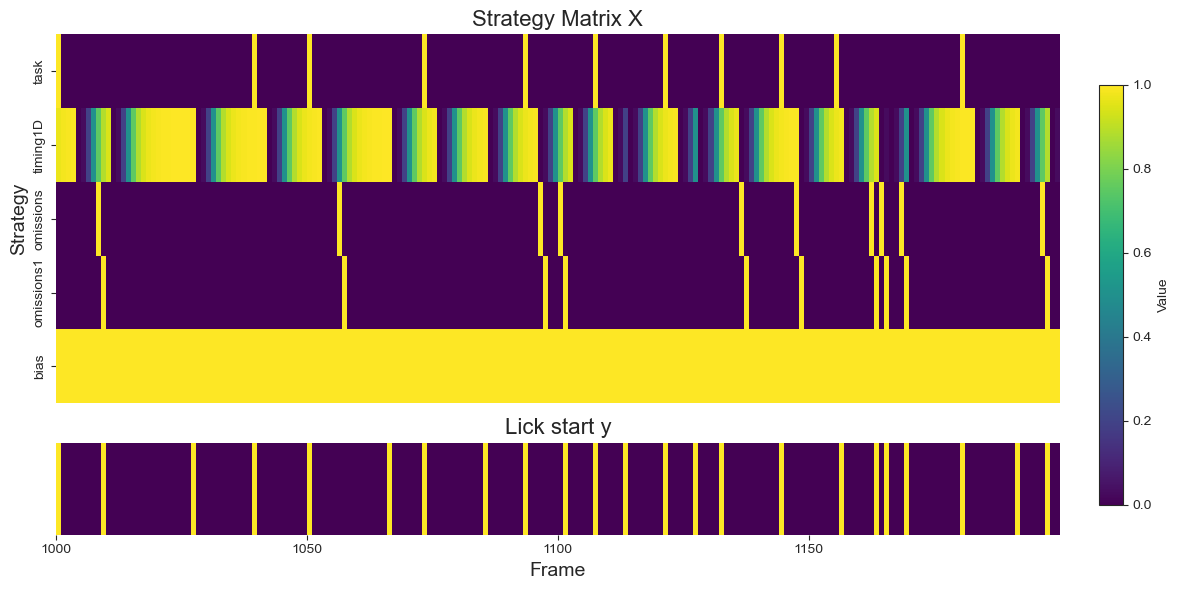

{'task': 1, 'timing1D': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
Model Evidence: -1574.0059460633638
Cross Validation Analysis
running fold 9
Lesion Analysis
{'timing1D': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
{'task': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
{'task': 1, 'timing1D': 1, 'omissions1': 1, 'bias': 1}
{'task': 1, 'timing1D': 1, 'omissions': 1, 'bias': 1}
Visual Index: 16.52%
Timing Index: 1.05%
Omission Index: 0.01%
Post-Omission Index: 2.91%
Overall Strategy Index: 15.47
Dominant Strategy: Visual


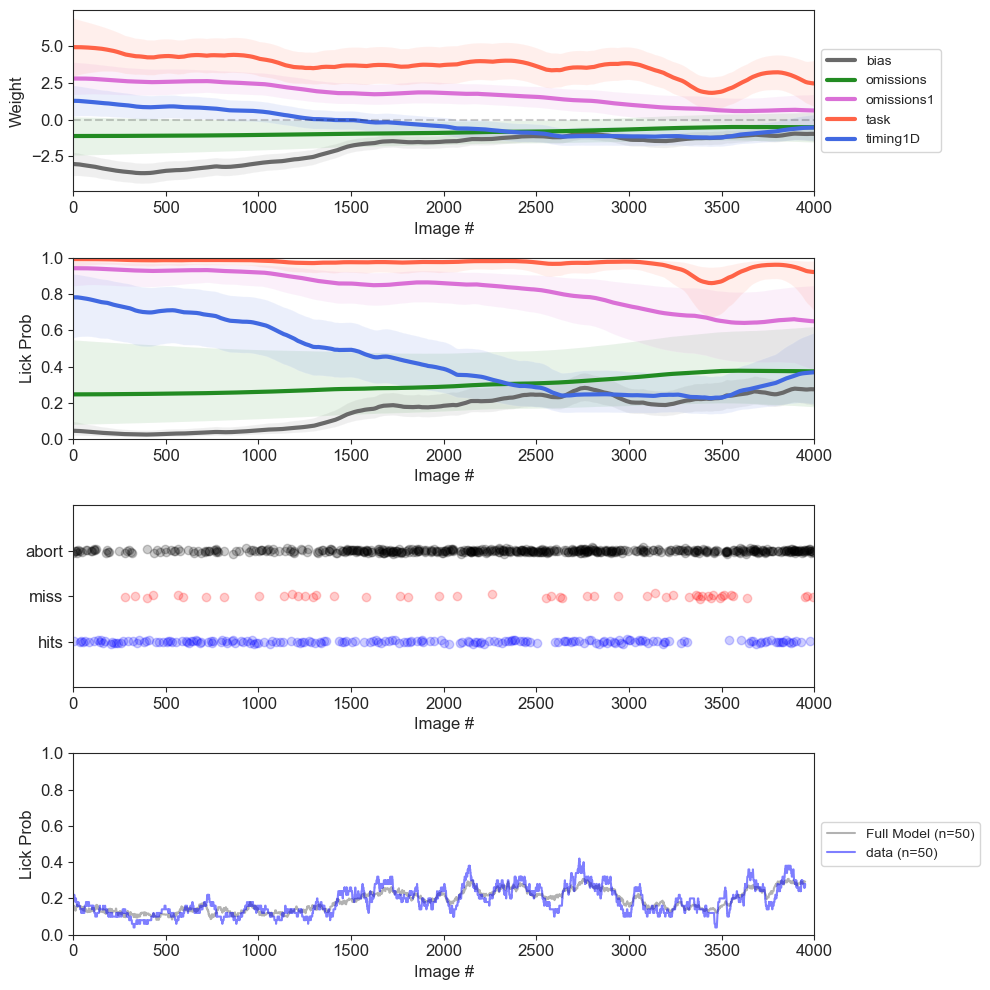

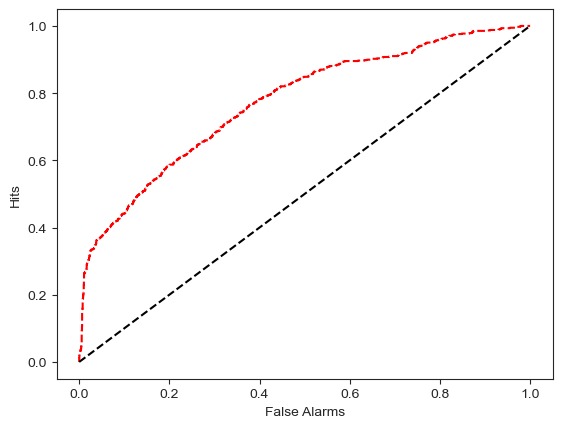

In [10]:
bsid = subset_sessions.index[0]
behavior_session = cache.get_behavior_session(bsid)
licks = behavior_session.licks
licks_annot = get_metrics.annotate_licks(licks, behavior_session)
stimulus_presentations = behavior_session.stimulus_presentations
stimulus_presentations = stimulus_presentations[stimulus_presentations['active']]
stim_table = get_metrics.annotate_bouts(licks_annot, stimulus_presentations)

format_options = {
                  'preprocess': 2, 
                  'timing_params': [-5,4],
                  'num_cv_folds': 10}

psydata = format_Xy.build_regressor(stim_table, format_options, behavior_session)

strategy_list = ['task', 'timing1D', 'omissions','omissions1', 'bias']


format_Xy.visualize_design(psydata['full_df'], strategy_list, f'{example_plot_dir}/weight_mat', t_start = 1000)

# this is for other non-recording sessions
if np.sum(stimulus_presentations.omitted) == 0:
    strategy_list.remove('omissions')
    strategy_list.remove('omissions1')
hyp, evd, wMode, credibleInt,weights = psy_funcs.fit_weights(psydata,strategy_list)
# Save to .npy file
np.save(f'{example_dir}/wMode.npy', wMode)
ypred,ypred_each = psy_funcs.compute_ypred(psydata, wMode,weights)
psy_funcs.plot_weights(wMode, weights,psydata,errorbar=credibleInt, ypred=ypred,
    filename=f"{example_plot_dir}/fit")
print('Model Evidence:', evd)

print("Cross Validation Analysis")
cross_psydata = psy.trim(psydata, 
END=int(np.floor(len(psydata['y'])/format_options['num_cv_folds'])\
*format_options['num_cv_folds'])) 
cross_results = psy_funcs.compute_cross_validation(cross_psydata, hyp, weights,
folds=format_options['num_cv_folds'])
cv_pred = psy_funcs.compute_cross_validation_ypred(cross_psydata, cross_results,ypred)
auc = psy_funcs.compute_model_roc(psydata['y'],cv_pred,plot_this=True)

print("Lesion Analysis")
minus_task = strategy_list.copy()
minus_task.remove('task')
_, evd_minus_task, _, _, _ = psy_funcs.fit_weights(psydata,minus_task)
minus_timing =  [s for s in strategy_list if 'timing' not in s]
_, evd_minus_timing, _, _, _ = psy_funcs.fit_weights(psydata,minus_timing)
minus_omit = strategy_list.copy()
minus_omit.remove('omissions')
_, evd_minus_omit, _, _, _ = psy_funcs.fit_weights(psydata,minus_omit)
minus_omit1 = strategy_list.copy()
minus_omit1.remove('omissions1')
_, evd_minus_omit1, _, _, _ = psy_funcs.fit_weights(psydata,minus_omit1)

# Calculate indices
visual_index = utils.calculate_index(evd, evd_minus_task)
timing_index = utils.calculate_index(evd, evd_minus_timing)
omission_index = utils.calculate_index(evd, evd_minus_omit)
post_omission_index = utils.calculate_index(evd, evd_minus_omit1)

# Calculate overall strategy index
strategy_index = visual_index - timing_index

print(f"Visual Index: {visual_index:.2f}%")
print(f"Timing Index: {timing_index:.2f}%")
print(f"Omission Index: {omission_index:.2f}%")
print(f"Post-Omission Index: {post_omission_index:.2f}%")
print(f"Overall Strategy Index: {strategy_index:.2f}")

# Determine dominant strategy
dominant_strategy = "Visual" if strategy_index > 0 else "Timing"
print(f"Dominant Strategy: {dominant_strategy}")

In [12]:
session_df = pd.DataFrame(columns = ['auc', 'evd', 'visual_index', 'timing_index', 'omission_index', 'post_omission_index','strategy_index'])


 Processing 1050987699


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')
/Users/xinzheng/Repos/swdb_2024_project/src_local/format_Xy.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


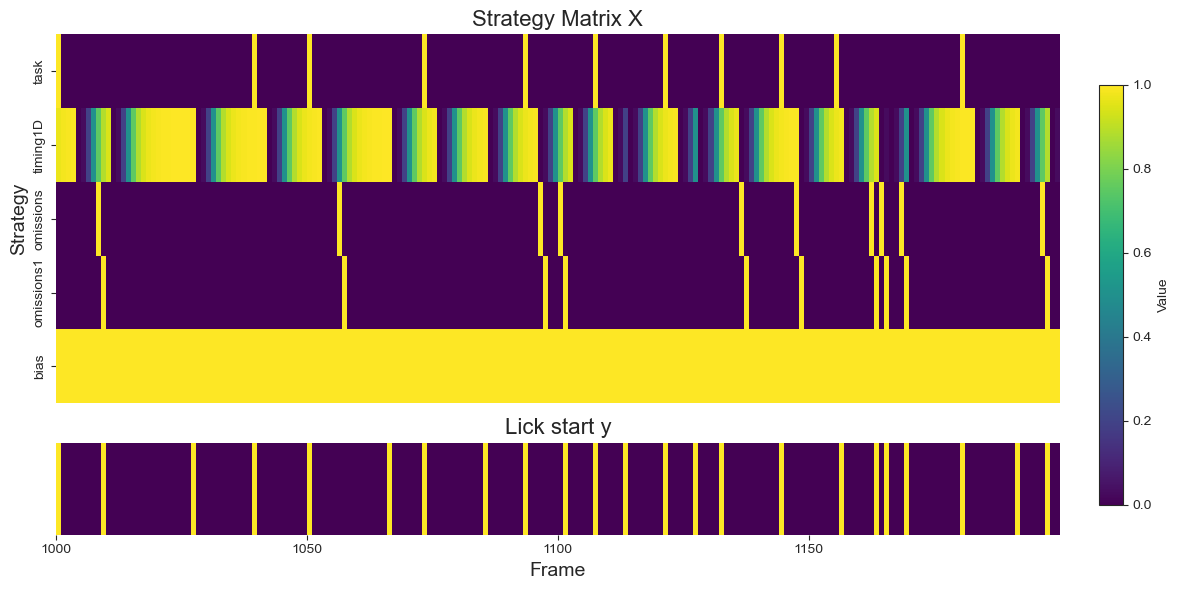

{'task': 1, 'timing1D': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
Model Evidence: -1574.0059460633638
Cross Validation Analysis
running fold 9
Lesion Analysis
{'timing1D': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
{'task': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
{'task': 1, 'timing1D': 1, 'omissions1': 1, 'bias': 1}
{'task': 1, 'timing1D': 1, 'omissions': 1, 'bias': 1}
Visual Index: 16.52%
Timing Index: 1.05%
Omission Index: 0.01%
Post-Omission Index: 2.91%
Overall Strategy Index: 15.47
Dominant Strategy: Visual

 Processing 1071409009


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')
/Users/xinzheng/Repos/swdb_2024_project/src_local/format_Xy.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


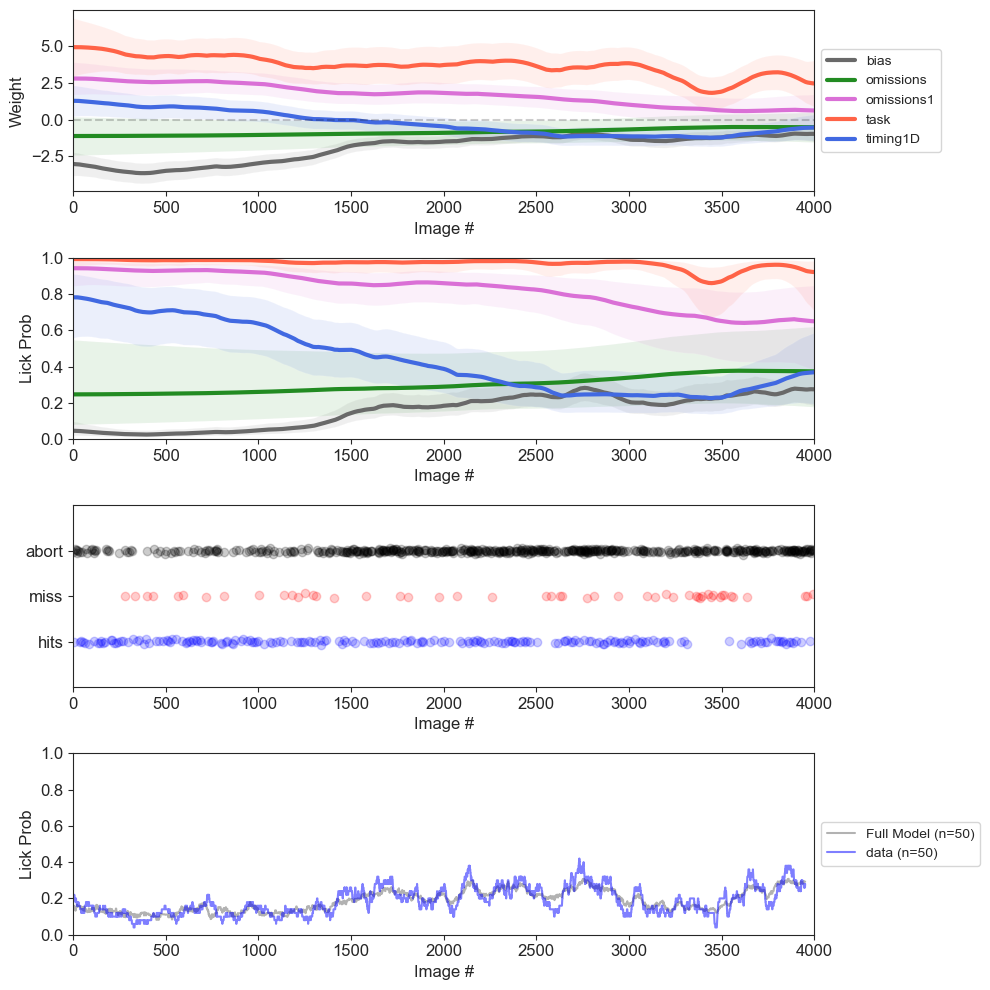

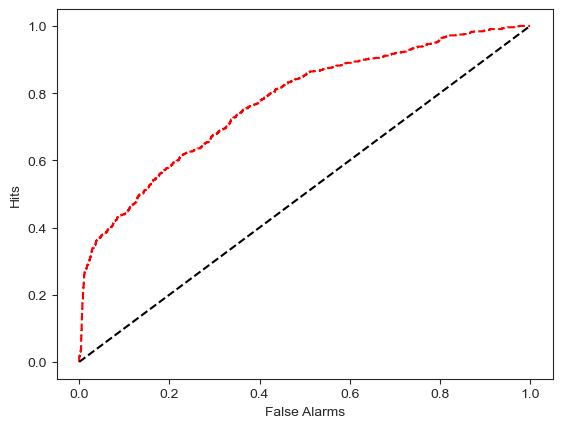

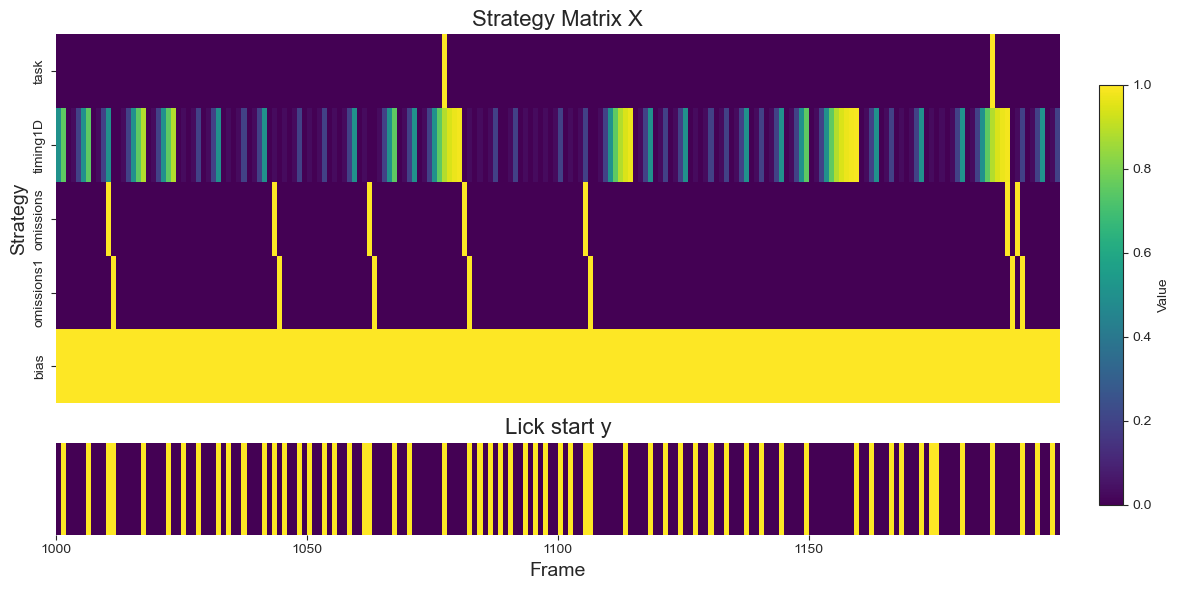

{'task': 1, 'timing1D': 1, 'omissions': 1, 'omissions1': 1, 'bias': 1}
Model Evidence: -1912.328602987851
Cross Validation Analysis
running fold 0

KeyboardInterrupt: 

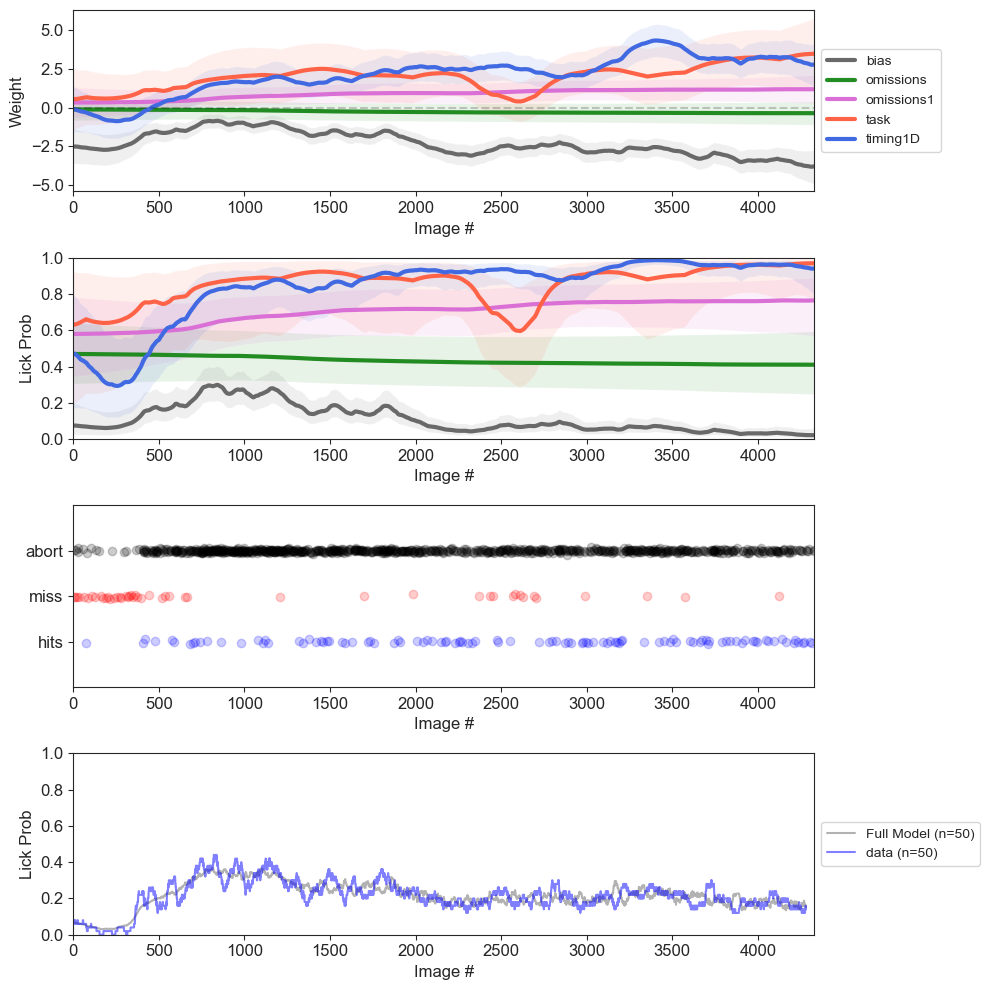

In [16]:
for bsid in subset_sessions.index:

    print(f'\n Processing {bsid}')

    dir = f'local_modelfit/ephys/{bsid}'
    os.makedirs(dir, exist_ok=True)

    plot_dir = f'plots/modelfit/ephys/{bsid}'
    os.makedirs(plot_dir, exist_ok=True)
    
    behavior_session = cache.get_behavior_session(bsid)
    licks = behavior_session.licks
    licks_annot = get_metrics.annotate_licks(licks, behavior_session)
    stimulus_presentations = behavior_session.stimulus_presentations
    stimulus_presentations = stimulus_presentations[stimulus_presentations['active']]
    stim_table = get_metrics.annotate_bouts(licks_annot, stimulus_presentations)

    format_options = {
                    'preprocess': 2, 
                    'timing_params': [-5,4],
                    'num_cv_folds': 10}

    psydata = format_Xy.build_regressor(stim_table, format_options, behavior_session)

    strategy_list = ['task', 'timing1D', 'omissions','omissions1', 'bias']


    format_Xy.visualize_design(psydata['full_df'], strategy_list, f'{plot_dir}/weight_mat', t_start = 1000)

    # this is for other non-recording sessions
    if np.sum(stimulus_presentations.omitted) == 0:
        strategy_list.remove('omissions')
        strategy_list.remove('omissions1')
    hyp, evd, wMode, credibleInt,weights = psy_funcs.fit_weights(psydata,strategy_list)
    # Save to .npy file
    np.save(f'{dir}/wMode.npy', wMode)
    ypred,ypred_each = psy_funcs.compute_ypred(psydata, wMode,weights)
    psy_funcs.plot_weights(wMode, weights,psydata,errorbar=credibleInt, ypred=ypred,
        filename=f"{plot_dir}/fit")
    print('Model Evidence:', evd)

    print("Cross Validation Analysis")
    cross_psydata = psy.trim(psydata, 
    END=int(np.floor(len(psydata['y'])/format_options['num_cv_folds'])\
    *format_options['num_cv_folds'])) 
    cross_results = psy_funcs.compute_cross_validation(cross_psydata, hyp, weights,
    folds=format_options['num_cv_folds'])
    cv_pred = psy_funcs.compute_cross_validation_ypred(cross_psydata, cross_results,ypred)
    auc = psy_funcs.compute_model_roc(psydata['y'],cv_pred,plot_this=True)

    print("Lesion Analysis")
    minus_task = strategy_list.copy()
    minus_task.remove('task')
    _, evd_minus_task, _, _, _ = psy_funcs.fit_weights(psydata,minus_task)
    minus_timing =  [s for s in strategy_list if 'timing' not in s]
    _, evd_minus_timing, _, _, _ = psy_funcs.fit_weights(psydata,minus_timing)
    minus_omit = strategy_list.copy()
    minus_omit.remove('omissions')
    _, evd_minus_omit, _, _, _ = psy_funcs.fit_weights(psydata,minus_omit)
    minus_omit1 = strategy_list.copy()
    minus_omit1.remove('omissions1')
    _, evd_minus_omit1, _, _, _ = psy_funcs.fit_weights(psydata,minus_omit1)

    # Calculate indices
    visual_index = utils.calculate_index(evd, evd_minus_task)
    timing_index = utils.calculate_index(evd, evd_minus_timing)
    omission_index = utils.calculate_index(evd, evd_minus_omit)
    post_omission_index = utils.calculate_index(evd, evd_minus_omit1)

    # Calculate overall strategy index
    strategy_index = visual_index - timing_index

    print(f"Visual Index: {visual_index:.2f}%")
    print(f"Timing Index: {timing_index:.2f}%")
    print(f"Omission Index: {omission_index:.2f}%")
    print(f"Post-Omission Index: {post_omission_index:.2f}%")
    print(f"Overall Strategy Index: {strategy_index:.2f}")

    # Determine dominant strategy
    dominant_strategy = "Visual" if strategy_index > 0 else "Timing"
    print(f"Dominant Strategy: {dominant_strategy}")

    # Create a new row with the calculated values
    new_row = pd.DataFrame({
        'auc': [auc],
        'evd': [evd],
        'visual_index': [visual_index],
        'timing_index': [timing_index],
        'omission_index': [omission_index],
        'post_omission_index': [post_omission_index],
        'strategy_index': [strategy_index]
    }, index=[bsid])

    # Append the new row to session_df
    session_df = pd.concat([session_df, new_row])
    
session_df.to_csv('local_modelfit/ephys/strategy_summary.csv')